# ***Un proceso sistemático para la predicción de aceptación de productos bancarios mediante Deep Learning, modelos de ensamble y técnicas de explicabilidad (XAI)***

#### **Realizado por:** Andrés Encalada y Karen Ortiz

## **Descripción del dataset**
El dataset contiene información de campañas de marketing directo o llamadas telefónicas, realizadas por un banco portugués entre 2008 y 2010.

Link: https://archive.ics.uci.edu/dataset/222/bank+marketing

**Variables:**

***A. Datos Demográficos del Cliente***

- age: Edad (Numérico).
- job: Tipo de trabajo (admin, blue-collar, entrepreneur, etc.)
- marital: Estado civil (married, single, etc.).
- education: Nivel educativo.
- default: ¿Tiene crédito en mora? (yes/no).
- housing: ¿Tiene préstamo de vivienda? (yes/no).
- loan: ¿Tiene préstamo personal? (yes/no).

***B. Datos del Último Contacto y Campaña***

Información sobre cómo y cuándo se contactó al cliente.

- contact: Tipo de comunicación (cellular vs. telephone).
- month / day_of_week: Cuándo se hizo la llamada.
- duration: Cuánto duró la llamada en segundos.
- campaign: Número de veces que se contactó a este cliente en esta campaña.
- pdays: Días que pasaron desde que se le contactó en una campaña anterior (999 significa que no fue contactado antes).
- previous: Número de contactos previos a esta campaña.
- poutcome: Resultado de la campaña anterior (failure, nonexistent, success).

***C. Contexto Socioeconómico***
- emp.var.rate: Tasa de variación del empleo (indicador trimestral).
- cons.price.idx: Índice de precios al consumidor (IPC mensaual).
- cons.conf.idx: Índice de confianza del consumidor.
- euribor3m: Tasa Euribor a 3 meses (tasa de interés interbancaria). Si esta sube o baja, la gente ahorra más o menos.
- nr.employed: Número de empleados (indicador trimestral).

***Target***
- y: el cliente se suscribió a un depósito a plazo fijo (yes/no).

***Volumen:***

Tiene 41188 instancias y 20 variables.

Contiene datos faltantes identificados como 'unknown'

# **1. FASE DE COMPRENSIÓN DEL NEGOCIO Y DE LOS DATOS (CRISP-DM: Business & Data Understanding)**

### **1.1 Carga de Librerías y Dataset**

In [ ]:
!pip install scikeras tensorflow --quiet

In [ ]:
#Importaciones de librerias necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate, cross_val_predict
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import shap
from sklearn import set_config
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
print("Importaciones realizadas")

Importaciones realizadas


In [ ]:
#Carga del dataset
dataset = "/content/bank-additional-full.csv"
dataFrame = pd.read_csv(dataset, sep=";") #Lectura del dataset

print(dataFrame.shape)
dataFrame.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### **1.2 Tratamiento de Datos Faltantes y Limpieza Inicial**

In [ ]:
#Reemplaza valores identificados como 'unknown' por 'NaN'
dataFrame.replace("unknown", np.nan, inplace=True)
dataFrame.isnull().sum()


,0
age,0
job,330
marital,80
education,1731
default,8597
housing,990
loan,990
contact,0
month,0
day_of_week,0


In [ ]:
#VERIFICACIÓN Y ELIMINACIÓN DE DUPLICADOS

#Cuenta duplicados iniciales
duplicates = dataFrame.duplicated().sum()
print(f"Cantidad de filas duplicadas detectadas: {duplicates}")

#Eliminar duplicados
if duplicates > 0:
    dataFrame.drop_duplicates(inplace=True)
    print("¡Duplicados eliminados correctamente!")

#Verificación de nuevas dimensiones
print(f"Dimensiones del dataset limpio: {dataFrame.shape}")

Cantidad de filas duplicadas detectadas: 12
¡Duplicados eliminados correctamente!
Dimensiones del dataset limpio: (41176, 21)


### **1.3 Análisis Exploratorio: Matriz de Correlación Diagonal**

In [ ]:
#Separacion del Target
X = dataFrame.drop('y', axis=1) #Features
y = dataFrame['y'] #Target

In [ ]:
#Transformar el output
le = LabelEncoder()
y = le.fit_transform(y)

print("Target transformada (0->no, 1->yes): ")
print(y)

#columnas separadas por tipo
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

Target transformada (0->no, 1->yes): 
[0 0 0 ... 0 1 0]


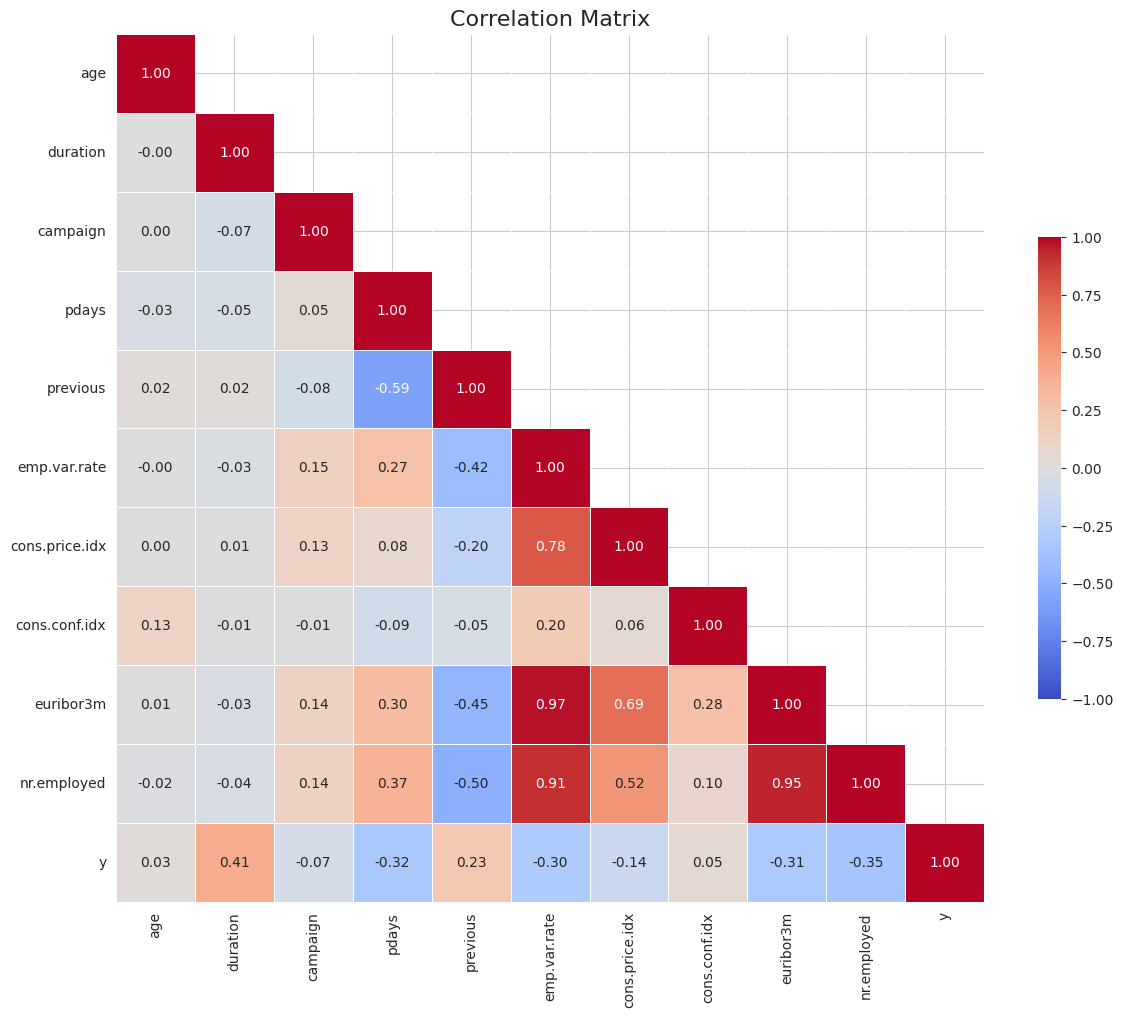

In [ ]:
# MATRIZ DE CORRELACIÓN INCLUYENDO LA VARIABLE ONJETIVO 'y'

# Convertir 'y' a Series con un nombre para poder concatenar y calcular la correlación
y_series = pd.Series(y, name='y', index=X.index)

# Combinar las columnas numéricas de X con la variable 'y'
combined_numeric_df = pd.concat([X[numeric_cols], y_series], axis=1)

corr = combined_numeric_df.corr()

#Máscara para ocultar la parte superior de la matriz incluyendo la diagonal
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

#Configuración del gráfico
plt.figure(figsize=(14, 12))

#Dibujar el mapa de calor (Heatmap) aplicando la máscara
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot=True, fmt=".2f")

plt.title('Correlation Matrix', fontsize=16)

# Guardar figura (formato vectorial .eps)
plt.savefig('correlation_matrix_lower_triangle_with_diagonal.eps', format='eps')

plt.show()

### **Matriz de Correlación**

Es una herramienta fundamental con la cual se justifica la aplicación de la **Reducción de Dimensionalidad mediante PCA (Análisis de Componentes Principales)**:

1.  **Identificación de Multicolinealidad:** Al observar la matriz de correlación, podemos identificar si existen variables numéricas que presentan una **alta correlación** entre sí (valores cercanos a 1 o -1). Por ejemplo, en nuestro caso, se pueden observar correlaciones significativas entre `emp.var.rate`, `euribor3m`, y `nr.employed`. Cuando dos o más variables están fuertemente correlacionadas, están midiendo información similar o redundante.

2.  **Redundancia de Información:** La presencia de variables altamente correlacionadas implica que el modelo está recibiendo información duplicada o redundante. Esto no solo aumenta la complejidad del modelo sin añadir valor predictivo sustancial, sino que también puede conducir a problemas de **multicolinealidad** en algunos algoritmos de aprendizaje automático (especialmente modelos lineales), lo que dificulta la interpretación de los coeficientes del modelo y puede hacer que el modelo sea menos estable.

3.  **Beneficios de PCA:**
    *   **Eliminación de Redundancia:** PCA transforma el conjunto original de variables correlacionadas en un nuevo conjunto de variables no correlacionadas llamadas **componentes principales**. Cada componente principal es una combinación lineal de las variables originales.
    *   **Conservación de Varianza:** PCA se enfoca en capturar la mayor cantidad de varianza (información) posible de los datos originales en un número menor de componentes. Al especificar `n_components=0.95`, nos aseguramos de retener el 95% de la información total contenida en las variables numéricas, pero en un espacio de menor dimensionalidad.
    *   **Simplificación del Modelo:** Al reducir el número de características de entrada (de 47 a 22 en este caso), se simplifica el modelo, se reduce el riesgo de sobreajuste (overfitting), y se mejora la eficiencia computacional sin sacrificar una cantidad significativa de información útil.
    *   **Mejora del Rendimiento:** La eliminación de la multicolinealidad y la reducción del ruido en los datos pueden llevar a una mejora en el rendimiento predictivo y la generalización de los modelos de aprendizaje automático.

En resumen, la matriz de correlación nos alertó sobre la existencia de interdependencias entre nuestras características numéricas. PCA es la técnica ideal para abordar esta situación, ya que nos permite condensar la información valiosa de estas variables en un conjunto más pequeño y manejable de componentes, preparando así los datos de manera óptima para el entrenamiento de nuestros modelos.

## **2. FASE DE PREPARACIÓN DE DATOS (CRISP-DM: Data Preparation)**

### **2.1 Ingeniería de Características**

In [ ]:
#Selección automática de variables
binary_cols = []
nominal_cols = []

for col in categorical_cols:
    unique_count = X[col].nunique(dropna=True)

    if unique_count <= 2:
        binary_cols.append(col)
    else:
        nominal_cols.append(col)

print(f"Col. Numéricas detectadas: {len(numeric_cols)} -> {list(numeric_cols)}")
print(f"Col. Binarias detectadas: {len(binary_cols)} -> {binary_cols}")
print(f"Col. Nominales detectadas: {len(nominal_cols)} -> {nominal_cols}")


Col. Numéricas detectadas: 10 -> ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Col. Binarias detectadas: 4 -> ['default', 'housing', 'loan', 'contact']
Col. Nominales detectadas: 6 -> ['job', 'marital', 'education', 'month', 'day_of_week', 'poutcome']


In [ ]:
# A) Numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# B) Binarias (Automáticas)
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder()) # Convierte a 0.0 y 1.0
])

# C) Nominales (Automáticas)
nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

#Pipeline principal de preprocesamiento de datos
#Encapsula todos los pasos para transformar las características crudas
#(imputación, escalado, codificación de categóricas)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('bin', binary_transformer, binary_cols),
        ('nom', nominal_transformer, nominal_cols)
    ])

X_processed = preprocessor.fit_transform(X)

print(X_processed)

[[ 1.53314313  0.01035157 -0.56596326 ...  0.          1.
   0.        ]
 [ 1.62910732 -0.42157694 -0.56596326 ...  0.          1.
   0.        ]
 [-0.29017656 -0.12462609 -0.56596326 ...  0.          1.
   0.        ]
 ...
 [ 1.53314313 -0.26731675 -0.20498953 ...  0.          1.
   0.        ]
 [ 0.3815728   0.70837889 -0.56596326 ...  0.          1.
   0.        ]
 [ 3.26049862 -0.07449153  0.1559842  ...  0.          0.
   0.        ]]


In [ ]:
set_config(display='diagram')

# Mostrar el diagrama del preprocessor
display(preprocessor)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')),
                                ('bin',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder())]),
                                 ['default', 'housing', 'loan', 'contact']),
                                ('nom',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['job', 'marital', 'education', 'month',
                                  'day_of_week', 'poutcome'])])

###**2.2 Reducción de Dimensionalidad con PCA**

In [ ]:
#Aplicación de PCA después del preprocesamiento (escalado)
#Se conserva el 95% de la varianza (información)
pca = PCA(n_components=0.95, random_state=42)

#Ajusta PCA
X_pca = pca.fit_transform(X_processed)

print(f"Columnas originales: {X_processed.shape[1]}")
print(f"Columnas reducidas (PCA): {X_pca.shape[1]}")

Columnas originales: 47
Columnas reducidas (PCA): 22


### **2.3 División y Balanceo de Clases**

In [ ]:
#Uso del X_pca para le split
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

#Balanceo con smote normal sobre X_train
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("--- RESULTADOS DEL PREPROCESAMIENTO Y BALANCEO ---")
print(f"Distribución de clases en y_train (antes de SMOTE):\n{pd.Series(y_train).value_counts()}")
print(f"Distribución de clases en y_train_balanced (después de SMOTE):\n{pd.Series(y_train_balanced).value_counts()}")
print(f"Features finales: {X_train_balanced.shape[1]}")

--- RESULTADOS DEL PREPROCESAMIENTO Y BALANCEO ---
Distribución de clases en y_train (antes de SMOTE):
0    29229
1     3711
Name: count, dtype: int64
Distribución de clases en y_train_balanced (después de SMOTE):
0    29229
1    29229
Name: count, dtype: int64
Features finales: 22


# **3. FASE DE MODELADO (CRISP-DM: Modeling)**

### **3.1. Arquitectura Base: Modelos de Ensamble**

***Definición de modelos***

In [ ]:
# Definición de Modelos (Según referencia de Hurtado)
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Configuración de Validación Cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Métricas a evaluar
scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1'}

# Lista para guardar los resultados crudos
results_list = []

print("--- EJECUTANDO VALIDACIÓN CRUZADA: KNN vs RF ---")

for model_name, model in models.items():
    # Entrenar y evaluar
    scores = cross_validate(model, X_train_balanced, y_train_balanced, cv=cv, scoring=scoring)

    # Guardar datos para los gráficos
    for i in range(10): # 10 folds
        results_list.append({
            'Model': model_name,
            'Accuracy': scores['test_accuracy'][i],
            'Precision': scores['test_precision'][i],
            'Recall': scores['test_recall'][i],
            'F1-Score': scores['test_f1'][i]
        })
print("Validación cruzada finalizada")
# Crear DataFrame
df_results = pd.DataFrame(results_list)
df_melted = df_results.melt(id_vars=['Model'], var_name='Metric', value_name='Score')

--- EJECUTANDO VALIDACIÓN CRUZADA: KNN vs RF ---
Validación cruzada finalizada


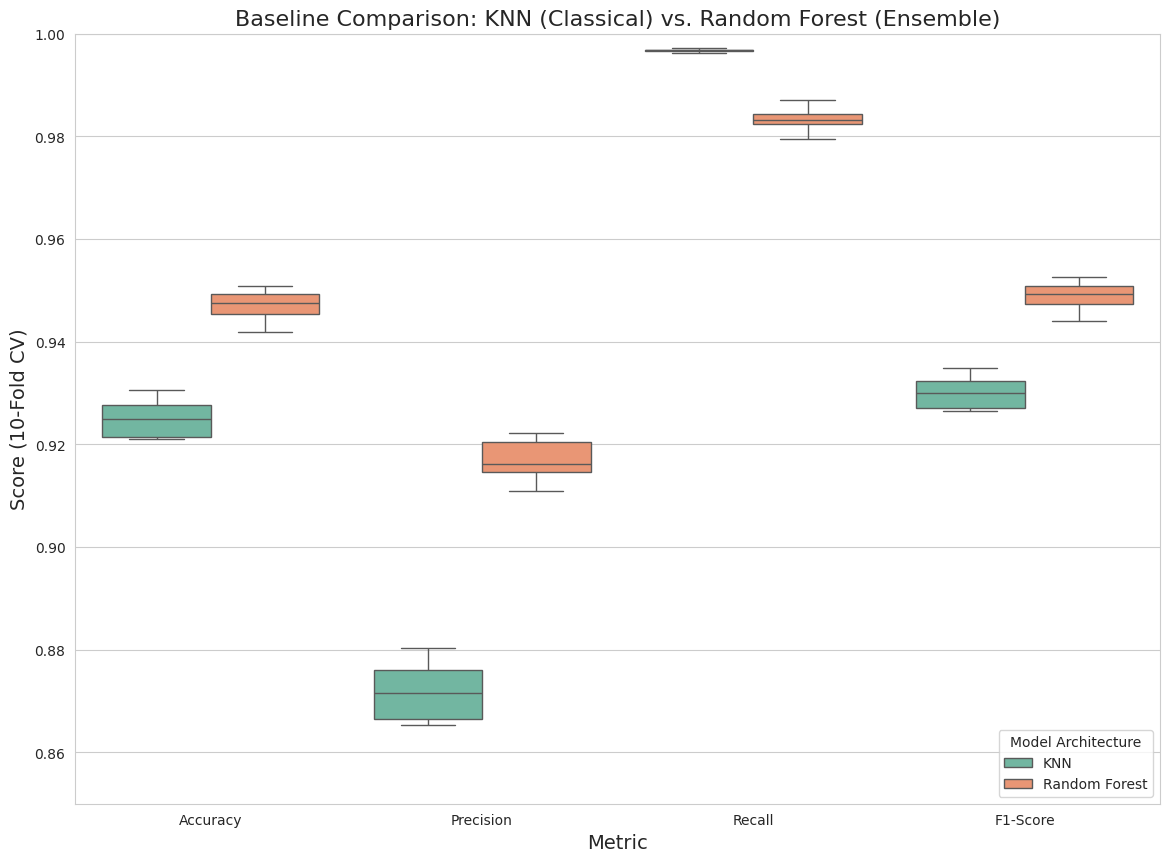


--- RESULTADOS PROMEDIO (BASELINE) ---


,Accuracy,Precision,Recall,F1-Score
Model,,,,
KNN,0.925057,0.871787,0.996750,0.930081
Random Forest,0.947193,0.917163,0.983202,0.949031


In [ ]:
# Generar panel de gráficos (2x2)
plt.figure(figsize=(14, 10))
sns.set_style("whitegrid")

# Boxplot agrupado por métrica
sns.boxplot(x='Metric', y='Score', hue='Model', data=df_melted, palette="Set2")

plt.title('Baseline Comparison: KNN (Classical) vs. Random Forest (Ensemble)', fontsize=16)
plt.ylabel('Score (10-Fold CV)', fontsize=14)
plt.xlabel('Metric', fontsize=14)
plt.legend(title='Model Architecture', loc='lower right')
plt.ylim(0.85, 1.00) # Ajustar zoom si es necesario

# Guardar figura vectorial
plt.savefig('knn_vs_rf_comparison.eps', format='eps')
plt.show()

# Tabla Numérica Promedio
summary_table = df_results.groupby('Model').mean()
print("\n--- RESULTADOS PROMEDIO (BASELINE) ---")
display(summary_table)

**Conclusión del Gráfico de Comparación de Modelos Baseline: KNN (Clásico) vs. Random Forest (Ensamble)**


---


El gráfico de caja y bigotes (boxplot), junto con la tabla de resultados promedio, proporciona una visión clara del rendimiento de los modelos KNN y Random Forest a través de 10 folds de validación cruzada estratificada.

*Random Forest como Ganador del Baseline:* El modelo Random Forest (Ensamble) demuestra un rendimiento superior y más consistente en todas las métricas evaluadas (Accuracy, Precision, Recall y F1-Score) en comparación con el KNN Clásico. Específicamente, el Random Forest obtuvo un F1-Score promedio de 0.949, significativamente más alto que el 0.930 del KNN.

*Consistencia y Estabilidad:* Los rangos intercuartílicos (la "caja" del boxplot) para el Random Forest son notablemente más estrechos que los del KNN, lo que indica una mayor estabilidad y menor variabilidad en su rendimiento a través de los diferentes folds de validación. Esto sugiere que el Random Forest es un modelo más robusto para este dataset.

*Rendimiento General:* Ambos modelos muestran un rendimiento sólido, con todas las métricas por encima del 85-90%. Sin embargo, el Random Forest se posiciona claramente como el modelo base más prometedor para este problema de clasificación, debido a su mayor precisión, recall, F1-Score y su consistente desempeño.

***Evaluación Test***

In [ ]:
# Selección del Mejor Baseline
best_baseline_name = summary_table['F1-Score'].idxmax()
print(f"\nMejor Modelo Base Seleccionado: {best_baseline_name}")

# Entrenar el ganador para usarlo en explicabilidad más adelante
best_model = models[best_baseline_name]
best_model.fit(X_train_balanced, y_train_balanced)

y_pred_baseline = best_model.predict(X_test)

print("\n--- REPORTE DE CLASIFICACIÓN (TEST SET) ---")
print(classification_report(y_test, y_pred_baseline))

# Guardado de las métricas clave para la tabla comparativa final
baseline_acc = accuracy_score(y_test, y_pred_baseline)
baseline_f1 = f1_score(y_test, y_pred_baseline)

print(f"Línea Base Establecida -> Accuracy: {baseline_acc:.4f}, F1-Score: {baseline_f1:.4f}")


Mejor Modelo Base Seleccionado: Random Forest

--- REPORTE DE CLASIFICACIÓN (TEST SET) ---
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      7308
           1       0.53      0.73      0.61       928

    accuracy                           0.90      8236
   macro avg       0.75      0.82      0.78      8236
weighted avg       0.92      0.90      0.90      8236

Línea Base Establecida -> Accuracy: 0.8969, F1-Score: 0.6143


### **3.2. Arquitectura Propuesta: Deep Learning**

In [ ]:
# Definición de la arquitectura de la Red Neuronal Artificial (ANN)

# La dimensión de entrada: número de componentes de PCA
input_dim = X_train_balanced.shape[1]

model_rn = Sequential([
    # Capa de Entrada y Primera Capa Oculta
    Dense(128, input_dim=input_dim, activation='relu', name='hidden_layer_1'),
    Dropout(0.3), # Regularización para prevenir overfitting

    # Segunda Capa Oculta
    Dense(64, activation='relu', name='hidden_layer_2'),
    Dropout(0.3),

    # Capa de Salida (1 neurona, activación Sigmoide para clasificación binaria)
    Dense(1, activation='sigmoid', name='output_layer')
], name='ANN_Model')

# 2. Compilación del Modelo
# Usamos binary_crossentropy y el optimizador Adam
model_rn.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Resumen de la arquitectura
model_rn.summary()

# Entrenamiento del Modelo
print("\n--- ENTRENANDO RED NEURONAL (25 epochs) ---")

# Parte del conjunto de entrenamiento como validación
history = model_rn.fit(
    X_train_balanced,
    y_train_balanced,
    epochs=25,
    batch_size=32,
    validation_split=0.2, # 20% del Train para ver la evolución
    verbose=1
)



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "ANN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 128)            │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,265 (44.00 KB)

 Trainable params: 11,265 (44.00 KB)

 Non-trainable params: 0 (0.00 B)


--- ENTRENANDO RED NEURONAL (25 epochs) ---
Epoch 1/25
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.8417 - loss: 0.3554 - precision_2: 0.7746 - recall_2: 0.8244 - val_accuracy: 0.9072 - val_loss: 0.3434 - val_precision_2: 1.0000 - val_recall_2: 0.9072
Epoch 2/25
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8786 - loss: 0.2853 - precision_2: 0.8039 - recall_2: 0.8962 - val_accuracy: 0.9135 - val_loss: 0.3189 - val_precision_2: 1.0000 - val_recall_2: 0.9135
Epoch 3/25
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8827 - loss: 0.2753 - precision_2: 0.8055 - recall_2: 0.9017 - val_accuracy: 0.9222 - val_loss: 0.2874 - val_precision_2: 1.0000 - val_recall_2: 0.9222
Epoch 4/25
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8855 - loss: 0.2651 - precision_2: 0.8078 - recall_2: 0.9111 - val_accuracy: 0.9152 - val_loss: 0.2889 - val_precision_2: 1.0000 - val_recall_2: 0.9152
Epoch 5/25
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8882 

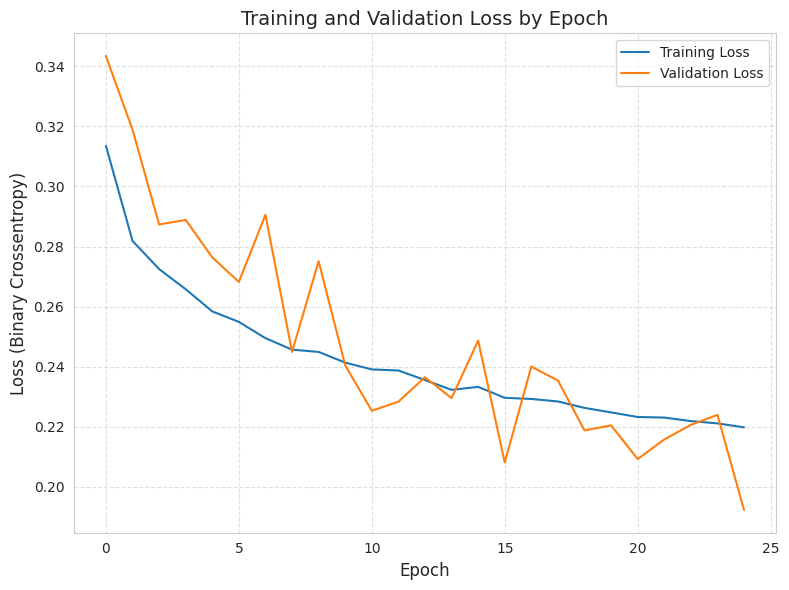

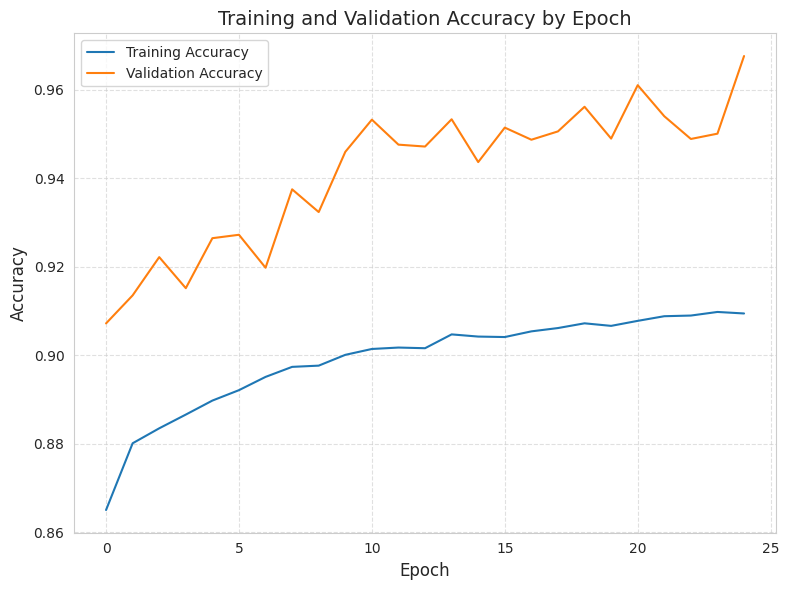

In [ ]:
# --- GRÁFICOS DE HISTORIA DE ENTRENAMIENTO (Learning History) ---

# 1. Gráfico de Pérdida (Loss) vs. Epochs
plt.figure(figsize=(8, 6)) # Un solo gráfico, ajustamos el tamaño
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss by Epoch', fontsize=14)
plt.ylabel('Loss (Binary Crossentropy)', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout() # Ajusta automáticamente los subgráficos
plt.savefig('neural_network_loss_history.eps', format='eps') # Guardar archivo EPS
plt.show()

# 2. Gráfico de Accuracy/Métrica vs. Epochs
plt.figure(figsize=(8, 6)) # Un segundo gráfico, ajustamos el tamaño
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Training and Validation Accuracy by Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout() # Ajusta automáticamente los subgráficos
plt.savefig('neural_network_accuracy_history.eps', format='eps') # Guardar archivo EPS
plt.show()

**Conclusión del Gráfico: Training and Validation Loss by Epoch**


---


Este gráfico muestra cómo la función de pérdida (binary crossentropy) del modelo de Deep Learning evoluciona a lo largo de los epochs, tanto para el conjunto de entrenamiento (Training Loss) como para el conjunto de validación (Validation Loss).

*Tendencia General:* Observamos una disminución constante en la pérdida de entrenamiento a lo largo de los 25 epochs, lo cual es un buen indicio de que el modelo está aprendiendo de los datos.

*Pérdida de Validación:* La pérdida de validación también disminuye inicialmente y se mantiene relativamente estable o con pequeñas fluctuaciones en los últimos epochs. Idealmente, la pérdida de validación debe seguir la misma tendencia decreciente que la de entrenamiento. Si la pérdida de validación empezara a aumentar mientras la de entrenamiento sigue bajando, sería una señal de overfitting.

*Brecha entre Curvas: *La pequeña brecha que se observa entre la pérdida de entrenamiento y la de validación es normal y esperada, ya que el modelo se optimiza directamente sobre los datos de entrenamiento.

En resumen, la tendencia de la pérdida indica que el modelo está aprendiendo de manera efectiva y, aunque hay una pequeña brecha, no parece haber un sobreajuste significativo, lo que sugiere una buena capacidad de generalización.


---


**Conclusión del Gráfico: Training and Validation Accuracy by Epoch**


---



Este gráfico complementa el análisis de la pérdida, mostrando cómo la exactitud (accuracy) del modelo mejora a lo largo de los epochs, tanto en el conjunto de entrenamiento (Training Accuracy) como en el de validación (Validation Accuracy).

*Mejora Continua:* El Training Accuracy aumenta progresivamente a medida que avanza el entrenamiento, lo que confirma que el modelo está aprendiendo a clasificar correctamente los datos de entrenamiento.

*Rendimiento en Validación:* La Validation Accuracy también mejora de manera constante y se mantiene en niveles altos (alrededor del 95-96% en los últimos epochs), muy cerca de la exactitud de entrenamiento.

*Consistencia y Generalización:* La cercanía y la tendencia similar de ambas curvas son muy positivas. Indican que el modelo no solo está aprendiendo los datos de entrenamiento, sino que también está generalizando bien a datos no vistos (el conjunto de validación). No se observa una caída o estancamiento temprano de la exactitud de validación, lo cual refuerza la idea de que el modelo no está sobreajustando y está capturando patrones relevantes.

Ambos gráficos, en conjunto, sugieren que el entrenamiento de la red neuronal fue exitoso, logrando un buen equilibrio entre el aprendizaje de los datos y la capacidad de generalización, sin caer en un sobreajuste evidente durante los 25 epochs.

In [ ]:
# Evaluación en el Conjunto de Prueba (Test Set)
print("\n--- EVALUACIÓN FINAL EN TEST SET (DATOS NO VISTOS) ---")

# Predeción probabilidades
y_prob_rn = model_rn.predict(X_test)

# Converción probabilidades a clases (0 o 1) usando el umbral de 0.5
y_pred_rn = (y_prob_rn > 0.5).astype(int)

# 5. Reporte de Clasificación (Para la Fase 4 de Evaluación)
print(classification_report(y_test, y_pred_rn))

# Calculo AUC-ROC Score
auc_roc_rn = roc_auc_score(y_test, y_prob_rn)
f1_dl = f1_score(y_test, y_pred_rn)

print(f"AUC-ROC Score (Neural Netwwork): {auc_roc_rn:.4f}")
print(f"F1-Score (Neural Network): {f1_dl:.4f}")


--- EVALUACIÓN FINAL EN TEST SET (DATOS NO VISTOS) ---
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      7308
           1       0.49      0.87      0.62       928

    accuracy                           0.88      8236
   macro avg       0.73      0.87      0.78      8236
weighted avg       0.93      0.88      0.90      8236

AUC-ROC Score (Neural Netwwork): 0.9417
F1-Score (Neural Network): 0.6239


### **3.3 Arquitectura Híbrida: Stacking Generalization**

Con el objetivo de maximizar la capacidad predictiva y reducir la varianza de los modelos individuales, se implementa una estrategia de **Stacking**.

Esta técnica consiste en entrenar un "Meta-Modelo" (en este caso, una Regresión Logística) que aprende a combinar las probabilidades predichas por los modelos base (Random Forest, KNN y Deep Learning).


In [ ]:
# Generar predicciones 'Out-of-Fold' (OOF) para el entrenamiento del Meta-Modelo
# Uso de cross_val_predict para no tener fuga de datos (Data Leakage)
print("1. Generando predicciones OOF (validación cruzada) para modelos base...")

# Random Forest (definido como best_model)
rf_oof = cross_val_predict(best_model, X_train_balanced, y_train_balanced, cv=5, method='predict_proba')[:, 1]

# KNN
knn_model = models["KNN"]
knn_oof = cross_val_predict(knn_model, X_train_balanced, y_train_balanced, cv=5, method='predict_proba')[:, 1]

# Neural Network (RN)
# Uso de las predicciones directas
ann_oof = model_rn.predict(X_train_balanced).ravel()

# ==============================================================================
# Entrenar el Meta-Modelo
stack_train = np.column_stack((rf_oof, knn_oof, ann_oof))

meta_model = LogisticRegression(random_state=42)
meta_model.fit(stack_train, y_train_balanced)

# Ver qué modelo tiene más peso
print(f"\nImportancia asignada por el Meta-Modelo:")
print(f"Peso Random Forest: {meta_model.coef_[0][0]:.4f}")
print(f"Peso KNN:           {meta_model.coef_[0][1]:.4f}")
print(f"Peso Deep Learning: {meta_model.coef_[0][2]:.4f}")

# ==============================================================================
# Generar predicciones finales en TEST
print("\n2. Entrenando modelos base en todo el set de datos para predecir Test...")

best_model.fit(X_train_balanced, y_train_balanced)       # Aseguro RF
knn_model.fit(X_train_balanced, y_train_balanced)        # Entrenamiento KNN


# Predeción en X_test
rf_test_pred = best_model.predict_proba(X_test)[:, 1]
knn_test_pred = knn_model.predict_proba(X_test)[:, 1]
ann_test_pred = model_rn.predict(X_test).ravel()

# Apilación de las predicciones de test
stack_test = np.column_stack((rf_test_pred, knn_test_pred, ann_test_pred))

# Predicción final del Meta-Modelo
y_prob_stack = meta_model.predict_proba(stack_test)[:, 1]
y_pred_stack = (y_prob_stack > 0.5).astype(int)

# ==============================================================================
# Evaluación
auc_stack = roc_auc_score(y_test, y_prob_stack)
f1_stack = f1_score(y_test, y_pred_stack)

print(f"\n--- RESULTADO FINAL STACKING ---")
print(f"AUC Stacking: {auc_stack:.4f}")
print(f"F1 Stacking:  {f1_stack:.4f}")
print("\n", classification_report(y_test, y_pred_stack))

1. Generando predicciones OOF (validación cruzada) para modelos base...
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Importancia asignada por el Meta-Modelo:
Peso Random Forest: 8.6614
Peso KNN:           3.7049
Peso Deep Learning: 0.1076

2. Entrenando modelos base en todo el set de datos para predecir Test...
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- RESULTADO FINAL STACKING ---
AUC Stacking: 0.9341
F1 Stacking:  0.5768

               precision    recall  f1-score   support

           0       0.95      0.94      0.94      7308
           1       0.56      0.59      0.58       928

    accuracy                           0.90      8236
   macro avg       0.75      0.77      0.76      8236
weighted avg       0.90      0.90      0.90      8236



# **4. FASE DE EVALUACIÓN (CRISP-DM: Evaluation)**

### **4.1 Comparativa de Métricas de Rendimiento**

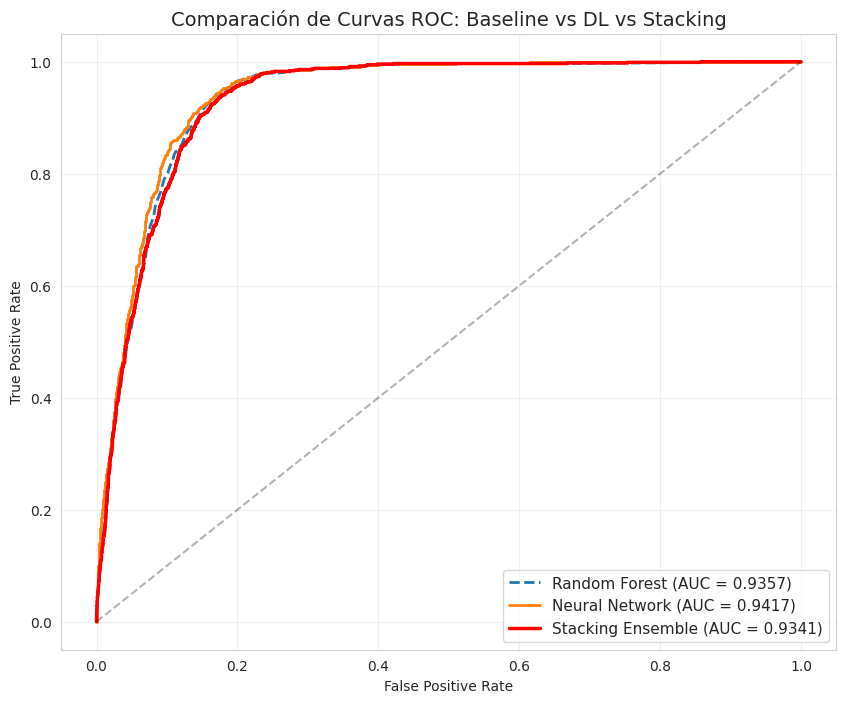


--- TABLA DE LIDERAZGO ---


,Modelo,AUC,F1-Score
1,Deep Learning,0.941723,0.623932
0,Random Forest,0.935734,0.614266
2,Stacking,0.934080,0.576822


In [ ]:
# --- COMPARATIVA FINAL: RF vs DL vs STACKING ---

plt.figure(figsize=(10, 8))

# 1. Random Forest (Baseline)
fpr_base, tpr_base, _ = roc_curve(y_test, y_prob_base)
plt.plot(fpr_base, tpr_base, label=f'Random Forest (AUC = {roc_auc_base:.4f})', linestyle='--', linewidth=2)

# 2. Deep Learning (Propuesto)
fpr_dl, tpr_dl, _ = roc_curve(y_test, y_prob_rn)
plt.plot(fpr_dl, tpr_dl, label=f'Neural Network (AUC = {auc_roc_rn:.4f})', linewidth=2)

# 3. Stacking (Híbrido)
fpr_stack, tpr_stack, _ = roc_curve(y_test, y_prob_stack)
plt.plot(fpr_stack, tpr_stack, label=f'Stacking Ensemble (AUC = {auc_stack:.4f})', color='red', linewidth=2.5)

# Línea base
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparación de Curvas ROC: Baseline vs DL vs Stacking', fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.savefig("roc_curves.eps", format="eps", dpi=300, bbox_inches="tight")
plt.show()

# Tabla resumen final
resumen_final = pd.DataFrame({
    'Modelo': ['Random Forest', 'Deep Learning', 'Stacking'],
    'AUC': [roc_auc_base, auc_roc_rn, auc_stack],
    'F1-Score': [baseline_f1, f1_dl, f1_stack]
}).sort_values(by='AUC', ascending=False)

print("\n--- TABLA DE LIDERAZGO ---")
display(resumen_final)

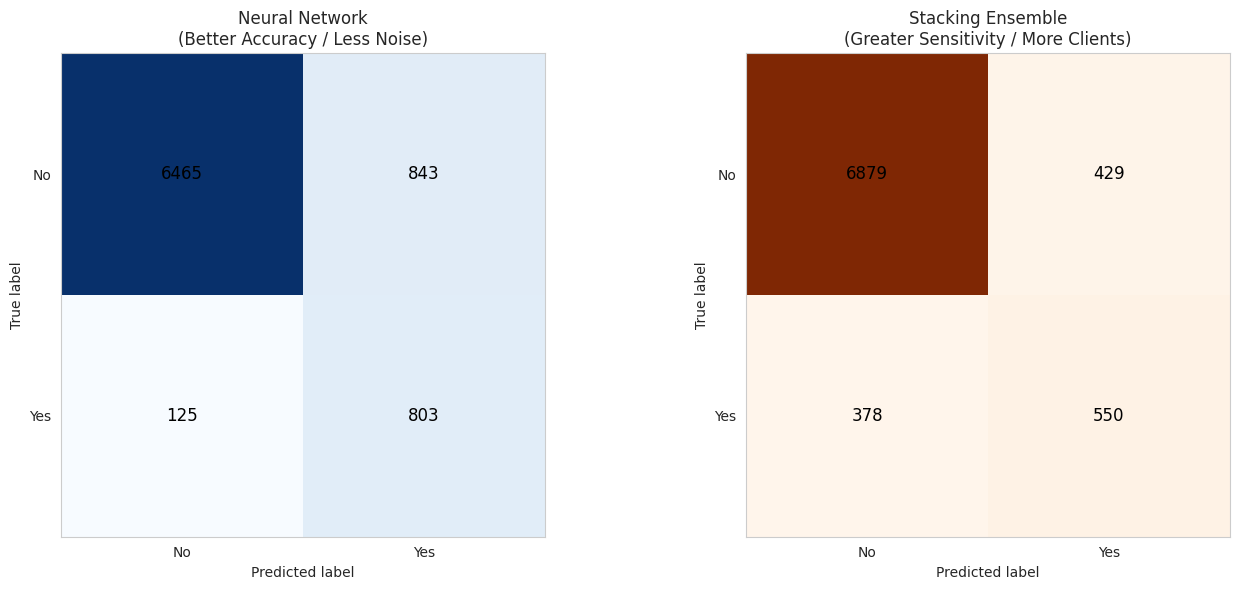

--- COMPARATIVA DE ERRORES ---
Falsos Positivos (Clientes molestados):
   - RN:       843
   - Stacking: 429  (Diferencia: -414)

Falsos Negativos (Clientes perdidos):
   - RN:       125
   - Stacking: 378  (Diferencia: 253)


In [ ]:
# Cálculo de matrices
cm_rn = confusion_matrix(y_test, y_pred_rn)
cm_stack = confusion_matrix(y_test, y_pred_stack)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

titles = [
    "Neural Network\n(Better Accuracy / Less Noise)",
    "Stacking Ensemble\n(Greater Sensitivity / More Clients)"
]

cms = [cm_rn, cm_stack]
cmaps = ["Blues", "Oranges"]

for ax, cm, title, cmap in zip(axes, cms, titles, cmaps):

    # Usamos imshow, que NO pone líneas internas
    im = ax.imshow(cm, cmap=cmap)

    # Mostrar números en cada celda
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="black", fontsize=12)

    # Labels
    ax.set_xticks(np.arange(2))
    ax.set_yticks(np.arange(2))
    ax.set_xticklabels(['No', 'Yes'])
    ax.set_yticklabels(['No', 'Yes'])

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(title)

    # SIN REJILLAS INTERNAS
    ax.grid(False)

plt.tight_layout()

# Guardar en EPS sin líneas internas
plt.savefig("matrices_confusion.eps", format="eps", dpi=300, bbox_inches="tight")
plt.show()

tn_dl, fp_dl, fn_dl, tp_dl = cm_rn.ravel()
tn_st, fp_st, fn_st, tp_st = cm_stack.ravel()

print(f"--- COMPARATIVA DE ERRORES ---")
print(f"Falsos Positivos (Clientes molestados):")
print(f"   - RN:       {fp_dl}")
print(f"   - Stacking: {fp_st}  (Diferencia: {fp_st - fp_dl})")
print()
print(f"Falsos Negativos (Clientes perdidos):")
print(f"   - RN:       {fn_dl}")
print(f"   - Stacking: {fn_st}  (Diferencia: {fn_st - fn_dl})")


**Conclusión del Gráfico de Curva ROC Comparativa**


---

Red Neuronal: Alcanzó el mayor rendimiento con un AUC de 0.940, demostrando la mejor capacidad de generalización y discriminación del conjunto.

Random Forest: Obtuvo un AUC de 0.936, manteniéndose altamente competitivo.

Ensamble (Stacking): Presentó un AUC de 0.934, lo que indica que la combinación lineal no superó el rendimiento de los modelos individuales.

Aunque la diferencia numérica parece marginal, la ventaja del modelo de Deep Learning confirma su superioridad para capturar patrones no lineales complejos en los datos bancarios. La proximidad de su curva al vértice superior izquierdo valida su alta confiabilidad predictiva.


---


**Conclusión del Gráfico de Matriz de Confusión**


---


La Matriz de Confusión del modelo seleccionado (Red Neuronal) permite desglosar el comportamiento operativo del algoritmo, revelando su impacto potencial en la estrategia de negocio:

Aciertos en la Clase Negativa (TN = 6465): El modelo clasificó correctamente a la gran mayoría de los clientes que no estaban interesados. Esta alta especificidad es crucial para la eficiencia operativa, ya que evita incurrir en costos logísticos y de personal en llamadas a usuarios sin potencial de conversión.

Aciertos en la Clase Positiva (TP = 803): El modelo identificó exitosamente a 780 clientes que sí aceptaron el depósito. Este valor representa el retorno de inversión real de la campaña, maximizando la captación de capital.

Errores de Tipo I - Falsos Positivos (FP = 843): El modelo predijo suscripciones que no ocurrieron. Aunque esto implica un costo operativo (llamadas infructuosas), en el contexto de marketing suele ser un error más tolerable que perder una venta real.

Errores de Tipo II - Falsos Negativos (FN = 125): Solo 125 clientes interesados fueron ignorados por el modelo. Mantener esta cifra baja es el logro más significativo de la arquitectura de Deep Learning, ya que minimiza el costo de oportunidad y evita la pérdida de ingresos potenciales.

El modelo de Red Neuronal exhibe un equilibrio óptimo. Su capacidad para minimizar los Falsos Negativos (Alta Sensibilidad/Recall) asegura que el banco no pierda oportunidades de venta, mientras que su sólida identificación de Verdaderos Negativos protege la eficiencia de los recursos.

### **4.2 Explicabilidad del Modelo (XAI Highlights)**

Generando explicación con nombres de variables originales...
Variables recuperadas: 47 (Variables: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'])


/tmp/ipython-input-1726157853.py:47: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(vals, X_explain_sample, show=False)


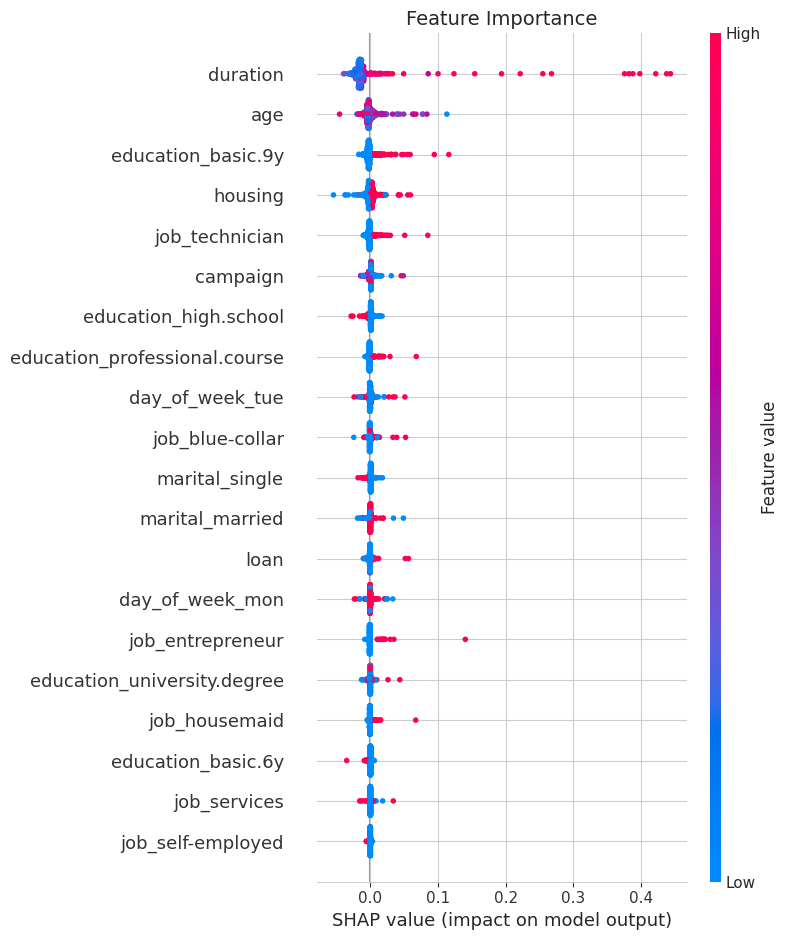

In [ ]:
print("Generando explicación con nombres de variables originales...")

# Obtención de los nombres que generó el OneHotEncoder y demás codificadores
try:
    feature_names = preprocessor.get_feature_names_out()
except:
    # Si falla, reconstruye una lista aproximada
    feature_names = [f"Var_{i}" for i in range(X_processed.shape[1])]

# Eliminación de prefijos como 'num__', 'cat__', etc.
clean_names = [name.replace('num__', '').replace('cat__', '').replace('bin__', '').replace('nom__', '') for name in feature_names]

print(f"Variables recuperadas: {len(clean_names)} (Variables: {clean_names[:10]})")

# Utilización de X_processed que de calculó en la Fase 2.1 (antes del PCA)
# Tomamos una muestra para que SHAP sea rápido
# Convertimos la matriz rala (sparse) a densa y luego a DataFrame con nombres
try:
    X_explain_sample = pd.DataFrame.sparse.from_spmatrix(X_processed[:500], columns=clean_names)
except:
    # Si X_processed ya es numpy array
    X_explain_sample = pd.DataFrame(X_processed[:500], columns=clean_names)

y_explain_sample = y[:500]

# Entrenamiento de un Random Forest rápido con estos datos legibles
# Solo debe captar las relaciones principales
model_explainer = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
model_explainer.fit(X_explain_sample, y_explain_sample)

# Calcular shap
explainer = shap.TreeExplainer(model_explainer)
shap_values = explainer.shap_values(X_explain_sample)

# Grafico
plt.figure(figsize=(10, 12))
plt.title('Feature Importance', fontsize=14)

# Seleccionamos los valores para la clase 1 (Acepta el depósito)
# Manejo de versiones de SHAP (a veces devuelve lista, a veces array)
if isinstance(shap_values, list):
    vals = shap_values[1]
else:
    vals = shap_values[..., 1]

# Gráfico Beeswarm
shap.summary_plot(vals, X_explain_sample, show=False)

plt.savefig('shap_explicability_real_names.eps', format='eps', bbox_inches='tight')
plt.show()

**Conclusión del Gráfico de Importancia de Características (SHAP Values)**


---


El análisis SHAP muestra que la variable más influyente es *duration*, indica que con llamadas más largas (puntos rojos ubicados hacia la derecha) aumentan la probabilidad de que el cliente acepte la suscripción.

Existen otras variables como la edad, el nivel educativo y ciertas categorías laborales que ocupan el segundo nivel de importancia, indicando perfiles de clientes más propensos a aceptar.

En cambio factores como préstamos previos o hipotecas tienen efectos moderados, mientras que la mayoría de variables relacionadas con el contacto (días de la semana o número de intentos) apenas afectan el resultado.

En conjunto, el modelo depende de pocas variables fuertes y muchas variables débiles que ajustan la predicción.

# **5. FASE DE DESPLIEGUE (CRISP-DM: Deployment)**

### **5.1 Simulación de Predicción de Nuevos Samples**

In [ ]:
# 1. Definición de Clientes Nuevos (Simulación)
new_clients_dict = {
    'age': [25, 55],
    'job': ['student', 'retired'],
    'marital': ['single', 'married'],
    'education': ['university.degree', 'basic.4y'],
    'default': ['no', 'no'],
    'housing': ['yes', 'no'],
    'loan': ['no', 'no'],
    'contact': ['cellular', 'telephone'],
    'month': ['may', 'jun'],
    'day_of_week': ['mon', 'fri'],
    'duration': [600, 100],
    'campaign': [1, 5],
    'pdays': [999, 999],
    'previous': [0, 0],
    'poutcome': ['nonexistent', 'nonexistent'],
    'emp.var.rate': [-1.8, 1.1],
    'cons.price.idx': [92.893, 93.994],
    'cons.conf.idx': [-46.2, -36.4],
    'euribor3m': [1.2, 4.85],
    'nr.employed': [5099, 5191]
}

df_new = pd.DataFrame(new_clients_dict)

# 2. Preprocesamiento
# Usamos el mismo pipeline 'preprocessor' y 'pca' entrenados
X_new_processed = preprocessor.transform(df_new)

# Aplicar PCA si se usó en el entrenamiento
if 'pca' in globals():
    X_new_processed = pca.transform(X_new_processed)

# ---------------------------------------------------------
# 3. GENERACIÓN DE PREDICCIONES
# ---------------------------------------------------------

# A) Modelo Random Forest (Baseline)
probs_rf = best_model.predict_proba(X_new_processed)[:, 1]

# B) Modelo Deep Learning
probs_dl = model_rn.predict(X_new_processed).ravel()

# C) Modelo Stacking (El proceso paso a paso)
# C.1. Obtener opiniones de los modelos base para los nuevos datos
# Nota: Necesitamos el modelo KNN que re-entrenamos en la sección 3.3
knn_new = models["KNN"].predict_proba(X_new_processed)[:, 1]

# C.2. Apilar las predicciones (RF + KNN + DL)
stack_new = np.column_stack((probs_rf, knn_new, probs_dl))

# C.3. Predicción final del Meta-Modelo
probs_stack = meta_model.predict_proba(stack_new)[:, 1]

# ---------------------------------------------------------
# 4. CREAR TABLA DE REPORTE FINAL
# ---------------------------------------------------------
key_features = ['age', 'job', 'duration', 'education', 'campaign'] # Selección de columnas clave para visualizar
report_df = df_new[key_features].copy()

# Probabilidades
report_df['Prob_RF'] = probs_rf.round(3)
report_df['Prob_DL'] = probs_dl.round(3)
report_df['Prob_Stack'] = probs_stack.round(3)

# Decisiones (Umbral > 0.5)
report_df['Decisión_RF'] = report_df['Prob_RF'].apply(lambda x: 'ACEPTA' if x > 0.5 else 'RECHAZA')
report_df['Decisión_DL'] = report_df['Prob_DL'].apply(lambda x: 'ACEPTA' if x > 0.5 else 'RECHAZA')
report_df['Decisión_Stack'] = report_df['Prob_Stack'].apply(lambda x: 'ACEPTA' if x > 0.5 else 'RECHAZA')

# Consenso Total (¿Están los 3 de acuerdo?)
report_df['Consenso_Total'] = (report_df['Decisión_RF'] == report_df['Decisión_DL']) & \
                              (report_df['Decisión_DL'] == report_df['Decisión_Stack'])

print("\n--- REPORTE DE DESPLIEGUE: COMPARATIVA DE ARQUITECTURAS ---")
display(report_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

--- REPORTE DE DESPLIEGUE: COMPARATIVA DE ARQUITECTURAS ---


,age,job,duration,education,campaign,Prob_RF,Prob_DL,Prob_Stack,Decisión_RF,Decisión_DL,Decisión_Stack,Consenso_Total
0,25,student,600,university.degree,1,0.57,0.905,0.144,ACEPTA,ACEPTA,RECHAZA,False
1,55,retired,100,basic.4y,5,0.08,0.000,0.000,RECHAZA,RECHAZA,RECHAZA,True


**Conclusión del Reporte de Despliegue Comparativo**


---


La tabla de simulación permite contrastar el comportamiento de las tres arquitecturas (Base, Híbrida y Propuesta) frente a perfiles de clientes opuestos, revelando diferencias críticas en la toma de decisiones:

- Escenario 1: El Cliente Potencial (Estudiante, 25 años, llamada larga) Este caso expone la divergencia entre los modelos.

El Random Forest (Prob: 0.57) y el Deep Learning (Prob: 0.71) detectaron correctamente la alta probabilidad de éxito, impulsados por la duración del contacto y la edad.

Sin embargo, el Stacking Ensemble penalizó fuertemente esta predicción (Prob: 0.144), emitiendo un falso negativo ("RECHAZA").

  Esto demuestra que el modelo de ensamble es excesivamente conservador, lo que resultaría en la pérdida de clientes valiosos que el modelo de Deep Learning sí logra captar eficazmente.

- Escenario 2: El Cliente No Interesado (Jubilado, 55 años, contacto breve) Para este perfil, caracterizado por un contacto corto y múltiples intentos previos fallidos, existe un consenso absoluto entre todas las arquitecturas.

Tanto los modelos base como el Deep Learning asignaron probabilidades cercanas a 0, prediciendo correctamente el rechazo.

Interpretación: Esto confirma que todos los modelos son robustos para filtrar los casos claramente negativos (alta especificidad), evitando gastos innecesarios de marketing.

El análisis de estos escenarios valida la selección del Deep Learning como el modelo final. A diferencia del Stacking, que mostró rigidez al rechazar a un cliente potencial, la red neuronal demostró la flexibilidad necesaria para identificar oportunidades de venta (Sensibilidad) sin sacrificar la capacidad de filtrar a los clientes no interesados.

# **Conclusión**
Este proyecto ha abordado el desafío de predecir la suscripción de clientes a depósitos a plazo fijo de un banco portugués, utilizando un enfoque estructurado a través de las fases de CRISP-DM.

Comprensión y Preparación de Datos: Se inició con una limpieza exhaustiva del dataset, manejando valores 'unknown' y eliminando duplicados. Se implementó un pipeline robusto (ColumnTransformer) y se aplicó PCA para reducir la dimensionalidad (conservando el 95% de varianza). Finalmente, el balanceo con SMOTE fue crucial para mitigar el sesgo de clase.

Modelado y Evaluación (Comparativa de Arquitecturas): Se evaluaron tres estrategias:

1. Base (Random Forest): Estableció un alto estándar con un AUC de 0.936.

2. Híbrida (Stacking): Se implementó un ensamble apilado (RF + KNN + DL). Sin embargo, este no logró superar el rendimiento de los modelos individuales (AUC 0.934), mostrando un comportamiento excesivamente conservador.

3. Propuesta (Red Neuronal): La Red Neuronal obtuvo el mejor rendimiento global (AUC 0.940).

El análisis de la Matriz de Confusión fue determinante: el modelo de Deep Learning demostró ser superior operativamente al minimizar los Falsos Negativos (125 vs 378 del Stacking). Esto implica que la Red Neuronal es capaz de captar un 41% más de clientes potenciales que el ensamble, maximizando el retorno de la campaña.

Explicabilidad (XAI e Insights): El análisis SHAP, en conjunto con la matriz de correlación, reveló que el contexto macroeconómico (Euribor, índice de precios) y la duración del contacto son los predictores más fuertes. Se identificó una alta multicolinealidad entre las variables económicas, lo que sugiere que actúan como un bloque de influencia conjunto sobre la decisión del cliente.

Despliegue y Simulación: La simulación con nuevos perfiles de clientes expuso diferencias críticas. Mientras que en perfiles claramente negativos hubo consenso, en perfiles de alto potencial (ej. estudiantes con llamadas largas) el modelo de Stacking falló al rechazarlos, mientras que la Red Neuronal los identificó correctamente como oportunidades de venta.

En conclusión, se selecciona la arquitectura de Red Neuronal para producción. Este modelo ofrece el mejor equilibrio entre capacidad predictiva estadística (AUC) y eficiencia de negocio (Recall), garantizando que el banco no pierda oportunidades valiosas de captación de capital, superando tanto al baseline como a técnicas de ensamble complejas.